## Example: $d=2$ Rayleigh-Benard convection in an annulus

$$\Omega = \{(x, y)~:~R_{\text{inner}}^2 < x^2 + y^2 < R_{\text{outer}}^2\}$$

$$\textbf{n}\cdot\textbf{u}|_{\partial\Omega}=0\implies\psi\vert_{\partial\Omega}=0$$

$$\partial\Omega_{\text{inner}} = \{(x, y)~:~ x^2 + y^2 = R_{\text{inner}}^2 \}$$

$$\partial\Omega_{\text{outer}} = \{(x, y)~:~ x^2 + y^2 = R_{\text{outer}}^2 \}$$

$$c_0(r)=\frac{\ln(R_{\text{outer}/r})}{\ln(R_{\text{outer}}/R_{\text{inner}})}+\mathcal{N}(r)~~,~~r=\sqrt{x^2 + y^2}$$

$$c\vert_{\partial\Omega_{\text{inner}}}=1$$

$$c\vert_{\partial\Omega_{\text{outer}}}=0$$

$$\textbf{e}_g=-\textbf{e}_r=-(\cos\theta\,\textbf{e}_x+\sin\theta\,\textbf{e}_y)~,~\theta=\tan^{-1}(y/x)$$

$$
\begin{align*}
\phi &= 1 \\
\mathsf{D} &= \mathsf{I} \\ 
\mathsf{K} &= \mathsf{I}\\ 
\mu &= 1 \\
\rho(c) &= -c
\end{align*}
$$

In [ ]:
import numpy as np
from ufl import SpatialCoordinate, sqrt
from lucifex.fdm import FiniteDifference, AB2, CN
from lucifex.mesh import annulus_mesh, mesh_boundary
from lucifex.solver import BoundaryConditions, OptionsPETSc
from lucifex.sim import integrate, configure_simulation
from lucifex.utils import CellType, SpatialPerturbation, triangulation
from lucifex.viz import plot_colormap, plot_mesh
from lucifex.io import write

from py.porous_convection import create_simulation


@configure_simulation(
    store_step=1,
    write_step=None,
)
def rayleigh_benard_annulus(
    Rinner: float = 1.0,
    Router: float = 2.0,
    Nradial: int = 100,
    cell: str = CellType.TRIANGLE,
    Ra: float = 5e2,
    c_eps: float = 1e-6,
    c_freq: int = 8,
    dt_max: float = 0.5,
    cfl_h: str | float = "hmin",
    cfl_courant: float = 0.75,
    D_adv: FiniteDifference | tuple[FiniteDifference, FiniteDifference] = (AB2, CN),
    D_diff: FiniteDifference = CN,
    psi_petsc: OptionsPETSc | None = None,
    c_petsc: OptionsPETSc | None = None,
    secondary: bool = False,
):
    r2 = lambda x: x[0]**2 + x[1]**2
    r = lambda x, sqrt: sqrt(r2(x))
    dr = (Router - Rinner) / Nradial
    Omega = annulus_mesh(dr, cell)(Rinner, Router)
    dOmega = mesh_boundary(
        Omega, 
        {
            "inner": lambda x: r2(x) - Rinner**2,
            "outer": lambda x: r2(x) - Router**2,
        },
    )
    c_bcs = BoundaryConditions(
        ("dirichlet", dOmega['inner'], 1.0),
        ("dirichlet", dOmega['outer'], 0.0),  
    )
    radial_noise = lambda x: c_eps * np.sin(c_freq * np.pi * (r(x, np.sqrt) - Rinner) / (Router - Rinner))
    c_ics = SpatialPerturbation(
        lambda x: np.log(Router / r(x, np.sqrt)) / np.log(Router / Rinner),
        radial_noise,
        Omega.geometry.x,
        c_eps,
        )   
    density = lambda c: -c
    x = SpatialCoordinate(Omega)
    egx = -x[0] / r(x, sqrt)
    egy = -x[1] / r(x, sqrt)
    simulation = create_simulation(
        Omega=Omega, 
        dOmega=dOmega, 
        egx=egx,
        egy=egy,
        Ra=Ra, 
        c_ics=c_ics, 
        c_bcs=c_bcs, 
        density=density, 
        dt_max=dt_max, 
        cfl_h=cfl_h, 
        cfl_courant=cfl_courant,
        D_adv=D_adv, 
        D_diff=D_diff, 
        psi_petsc=psi_petsc, 
        c_petsc=c_petsc, 
        secondary=secondary,
    )
    return simulation

In [3]:
Rinner = 1.0
Router = 2.0
simulation = rayleigh_benard_annulus(
    Rinner=Rinner,
    Router=Router,
    Nradial=32,
    Ra=300.0, 
    c_eps=1e-3,  
    c_freq=6, 
    D_adv=AB2,
    D_diff=CN,
)

n_stop = 200
dt_init = 1e-6
n_init = 5
integrate(simulation, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

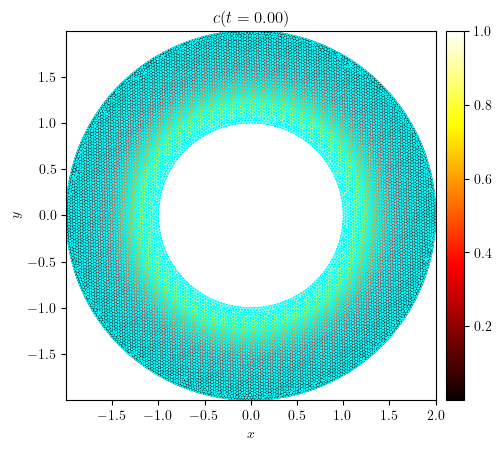

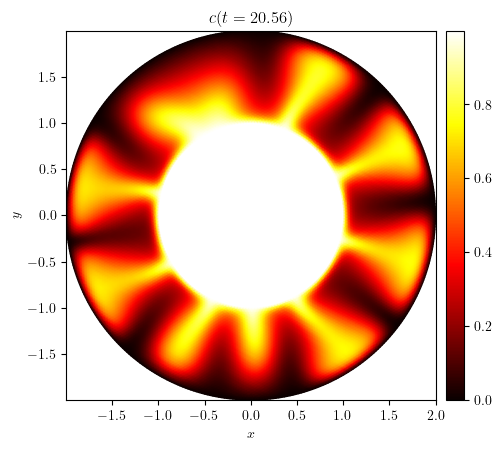

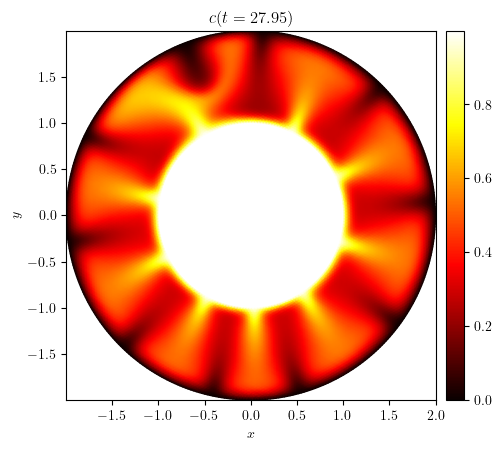

In [4]:
c = simulation['c']
mesh = c.function_space.mesh
mesh_tri = triangulation(mesh)
x, y = mesh_tri.x, mesh_tri.y

i_mid = int(0.5 * len(c.series))
time_indices = (0, i_mid,  -1)
for i in time_indices:
    c_tri = triangulation(c.series[i])
    fig, ax = plot_colormap(
        (mesh_tri, c_tri), 
        title=f'$c(t={c.time_series[i]:.2f})$',
        cartesian=False, 
    )
    if i == 0:
        plot_mesh(fig, ax, mesh, color='cyan', linewidth=0.5)
    write(fig, f'A13_rayleigh_benard_annulus_t={c.time_series[i]:.2f}', './figures', close=False, pickle=False)